In [27]:
%reset
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import glob
import os

import math
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pop_tools
from scipy.optimize import curve_fit
from pathlib import Path

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [28]:
grid = pop_tools.get_grid('POP_gx1v7')[['TAREA', 'KMT', 'TLAT', 'TLONG', 'REGION_MASK']]

In [29]:
def process(da):
    da['ALK_excess'] = da.ALK - da.ALK_ALT_CO2
    da['DIC_excess'] = da.DIC - da.DIC_ALT_CO2
    da['pCO2_SURF_excess'] = da.pCO2SURF - da.pCO2SURF_ALT_CO2
    return da

Read data

In [30]:
%%time

location  = 'North_Pacific_basin' #North_Atlantic_basin or North_Pacific_basin
polygon = '064'                    #for Atlantic: 0, 16, 36, 63; for Pacific: 105, 155 added 51, 64, 184, 185

# 1 year continuous release:
for i in range(1999,2015):
    print(i)
    dir_path = Path(f'/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Elizabeth_IRF_Experiments/Ensemble{polygon}_NP/smyle-fosi.{location}.alk-forcing-{location}.{polygon}-ensemble{i}/ocn/hist/')
    if dir_path.is_dir():
        print('yes')
        fpath = f'/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Elizabeth_IRF_Experiments/Ensemble{polygon}_NP/smyle-fosi.{location}.alk-forcing-{location}.{polygon}-ensemble{i}/ocn/hist/'
        globals()[f'da_{i}'] = xr.open_mfdataset(fpath + f'smyle-fosi.{location}.alk-forcing-{location}.{polygon}-ensemble{i}.pop.h.*.nc')


1999
yes
2000
yes
2001
yes
2002
yes
2003
yes
2004
yes
2005
yes
2006
yes
2007
yes
2008
yes
2009
yes
2010
yes
2011
yes
2012
yes
2013
yes
2014
yes
CPU times: user 1min 23s, sys: 3.64 s, total: 1min 27s
Wall time: 3min 37s


In [31]:
print('done')

done


In [32]:
#Month-long release for each month:
fpath = f'/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.{location}.alk-forcing-{location}.{polygon}-1999-01/ocn/hist/'
da_01 = xr.open_mfdataset(fpath + f'smyle-fosi.{location}.alk-forcing-{location}.{polygon}-1999-01.pop.h.*.nc')
print(da_01)

fpath = f'/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.{location}.alk-forcing-{location}.{polygon}-1999-04/ocn/hist/'
da_04 = xr.open_mfdataset(fpath + f'smyle-fosi.{location}.alk-forcing-{location}.{polygon}-1999-04.pop.h.*.nc')
print(da_04)

fpath = f'/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.{location}.alk-forcing-{location}.{polygon}-1999-07/ocn/hist/'
da_07 = xr.open_mfdataset(fpath + f'smyle-fosi.{location}.alk-forcing-{location}.{polygon}-1999-07.pop.h.*.nc')
print(da_07)

fpath = f'/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.{location}.alk-forcing-{location}.{polygon}-1999-10/ocn/hist/'
da_10 = xr.open_mfdataset(fpath + f'smyle-fosi.{location}.alk-forcing-{location}.{polygon}-1999-10.pop.h.*.nc')
print(da_10)

<xarray.Dataset>
Dimensions:                     (d2: 2, nlat: 384, nlon: 320, time: 180, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * time                        (time) object 0347-02-01 00:00:00 ... 0362-01...
  * z_t                         (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                         (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_bot                     (z_w_bot) float32 1e+03 2e+03 ... 5.5e+05
    ULONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                        (nlat, nlon) float64 dask.array

In [33]:
for i in range(1999,2015):
#for i in [1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2010,2011,2012,2013,2014]: #184 missing 2009
    process(globals()[f'da_{i}'])
da_01 = process(da_01)
da_04 = process(da_04)
da_07 = process(da_07)
da_10 = process(da_10)


In [34]:
def excess_dic(da):
    
    dic_inv = ((da.DIC - da.DIC_ALT_CO2) * da.dz * da.TAREA).sum(['z_t', 'nlat', 'nlon']) * 1e-9
    dic_inv = dic_inv.compute()
    
    return dic_inv

In [35]:
#Still need to multiply this by the number of days in total (since we're summing over months that have unequal day numbers)
def cal_added_ALk(da):
    '''Total added ALK, in mol'''
    #ALk_added_total = (da.ALK_FLUX * da.TAREA).sum(['time','nlat', 'nlon'])*1e-9*86400 # mol/day for that one month

    ALk_added_total = (da.ALK_FLUX * da.TAREA).sum(['nlat', 'nlon']).cumsum(['time'])*1e-9*86400 # mol/day for that one month
    return ALk_added_total.values

In [36]:

total_exc_alk_01  = (cal_added_ALk(da_01)*31)
total_exc_alk_04  = (cal_added_ALk(da_04)*30)
total_exc_alk_07  = (cal_added_ALk(da_07)*31)
total_exc_alk_10  = (cal_added_ALk(da_10)*31)

exc_dic_01  = excess_dic(da_01)
exc_dic_04  = excess_dic(da_04)
exc_dic_07  = excess_dic(da_07)
exc_dic_10  = excess_dic(da_10)


for i in range(1999,2015):
#for i in [1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2010,2011,2012,2013,2014]:
        print(i)
        globals()[f'total_exc_alk_{i}']= (cal_added_ALk(globals()[f'da_{i}'])*31)
        globals()[f'exc_dic_{i}'] = excess_dic(globals()[f'da_{i}'])
        globals()[f'ALk_added_{i}'] = (globals()[f'da_{i}'].ALK_FLUX * globals()[f'da_{i}'].TAREA).sum(['nlat', 'nlon'])*1e-9*86400  # mol/day


1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


In [37]:
print('done')

done


In [38]:
def exponential_tau(t, eta_max, ktau, gtau, htau):
    '''
    t: time
    eta_max: initial condition (this doubles as intrinsic "max" efficiency, ~0.81)
    ktau: e-folding time of gas exchange
    gtau: e-folding time of loss to the deep
    htau: e-folding time of gas exchange for the deep reservoir
    '''
    alpha = gtau/(ktau+gtau)
    tau_kg = 1.0/(1/ktau+1/gtau)
    return eta_max * (1 -  alpha*np.exp(-(1/ktau+1/gtau)*t)
                         - (1-alpha)*np.exp(-t/htau)
                         - (1-alpha)*(tau_kg/(htau - tau_kg))*(np.exp(-t/htau) - np.exp(-t/tau_kg))
                    )


def fit_params_tau(x_data, y_data, bounds=None, initial=None, pink=None, ping=None, pinh=None):
    '''Return fitted parameters'''
    # Perform the curve fitting
    if bounds is None:
        #bounds=[[ 0.849,  1.96,   0,       0],
        #        [ 0.851,  1.98,  2000,  10000]]
        bounds=[[ 0.80,  2,    0,       5],
                [ 0.88, 50 ,  2000,  10000]]
    if initial is None:
       initial = [(bounds[0][0]+bounds[1][0])/2,
                   np.clip(4,bounds[0][1],bounds[1][1]),
                   np.clip(25,bounds[0][2],bounds[1][2]),
                   np.clip(70,bounds[0][3],bounds[1][3])]
    if pink is not None:
      bounds[0][1] = pink
      bounds[1][1] = pink+0.01
      initial[1] = pink
    if ping is not None:
      bounds[0][2] = ping
      bounds[1][2] = ping+0.01
      initial[2] = ping
    if pinh is not None:
      bounds[0][3] = pinh
      bounds[1][3] = pinh+0.01
      initial[3] = pinh

    popt, pcov = curve_fit(exponential_tau, x_data, y_data, p0=initial,
                           method='trf', maxfev=10000, bounds=bounds)

    stdev = np.sqrt(np.diag(pcov))
    #print("%.2f %.1f %.1f %.1f"%tuple(stdev))
    return popt

In [39]:
def fit_to_curve_tau(x_data, y_data, s, show=False, onlydata=False, *args, **kwargs):
 
  if  len(y_data)<=1: # but abort if there's no data
    return np.nan,np.nan,np.nan,np.nan

  eta_max, ktau, gtau, htau = fit_params_tau(x_data, y_data, *args, **kwargs)
  if show:
    if onlydata:
      plt.plot(x_data, y_data)
    else:
      plt.plot(x_data, y_data, c="black",ls="dashed", label=None)
      plt.plot(x_data, exponential_tau(x_data, eta_max, ktau, gtau, htau), c = ["#BFBFFF","#A3A3FF","#7879FF","#4949FF"][s],
             label = r"%s: eta=%.2f t$_{gas}$=%.1fm t$_{loss}$=%.1fm,  t$_{slow}$=%.1fm"%(["Jan","Apr","Jul","Oct"][s],eta_max, ktau, gtau, htau))

    plt.legend(loc='lower right')
  return eta_max, ktau, gtau, htau

(0.0, 190.0)

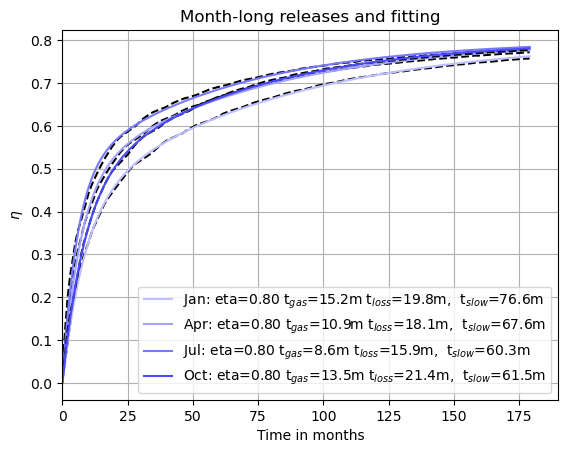

In [43]:
x_data = np.array(range(15*12))  # time in months

y_data_01 = (exc_dic_01/total_exc_alk_01).values; y_data_01 = y_data_01[~np.isnan(y_data_01)]  # get rid of nans
y_data_04 = (exc_dic_04/total_exc_alk_04).values; y_data_04 = y_data_04[~np.isnan(y_data_04)]  # get rid of nans
y_data_07 = (exc_dic_07/total_exc_alk_07).values; y_data_07 = y_data_07[~np.isnan(y_data_07)]  # get rid of nans
y_data_10 = (exc_dic_10/total_exc_alk_10).values; y_data_10 = y_data_10[~np.isnan(y_data_10)]  # get rid of nans

[eta_max_01, ktau_01, gtau_01, htau_01] = fit_to_curve_tau(x_data,y_data_01,0,show=True)
[eta_max_04, ktau_04, gtau_04, htau_04] = fit_to_curve_tau(x_data,y_data_04,1,show=True)
[eta_max_07, ktau_07, gtau_07, htau_07] = fit_to_curve_tau(x_data,y_data_07,2,show=True)
[eta_max_10, ktau_10, gtau_10, htau_10] = fit_to_curve_tau(x_data,y_data_10,3,show=True)


plt.ylabel('$\eta$')
plt.xlabel('Time in months')
plt.title('Month-long releases and fitting')
plt.grid('on')
plt.xlim([0,190])


1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


Text(0.5, 1.0, 'Ensemble Results for January -- California')

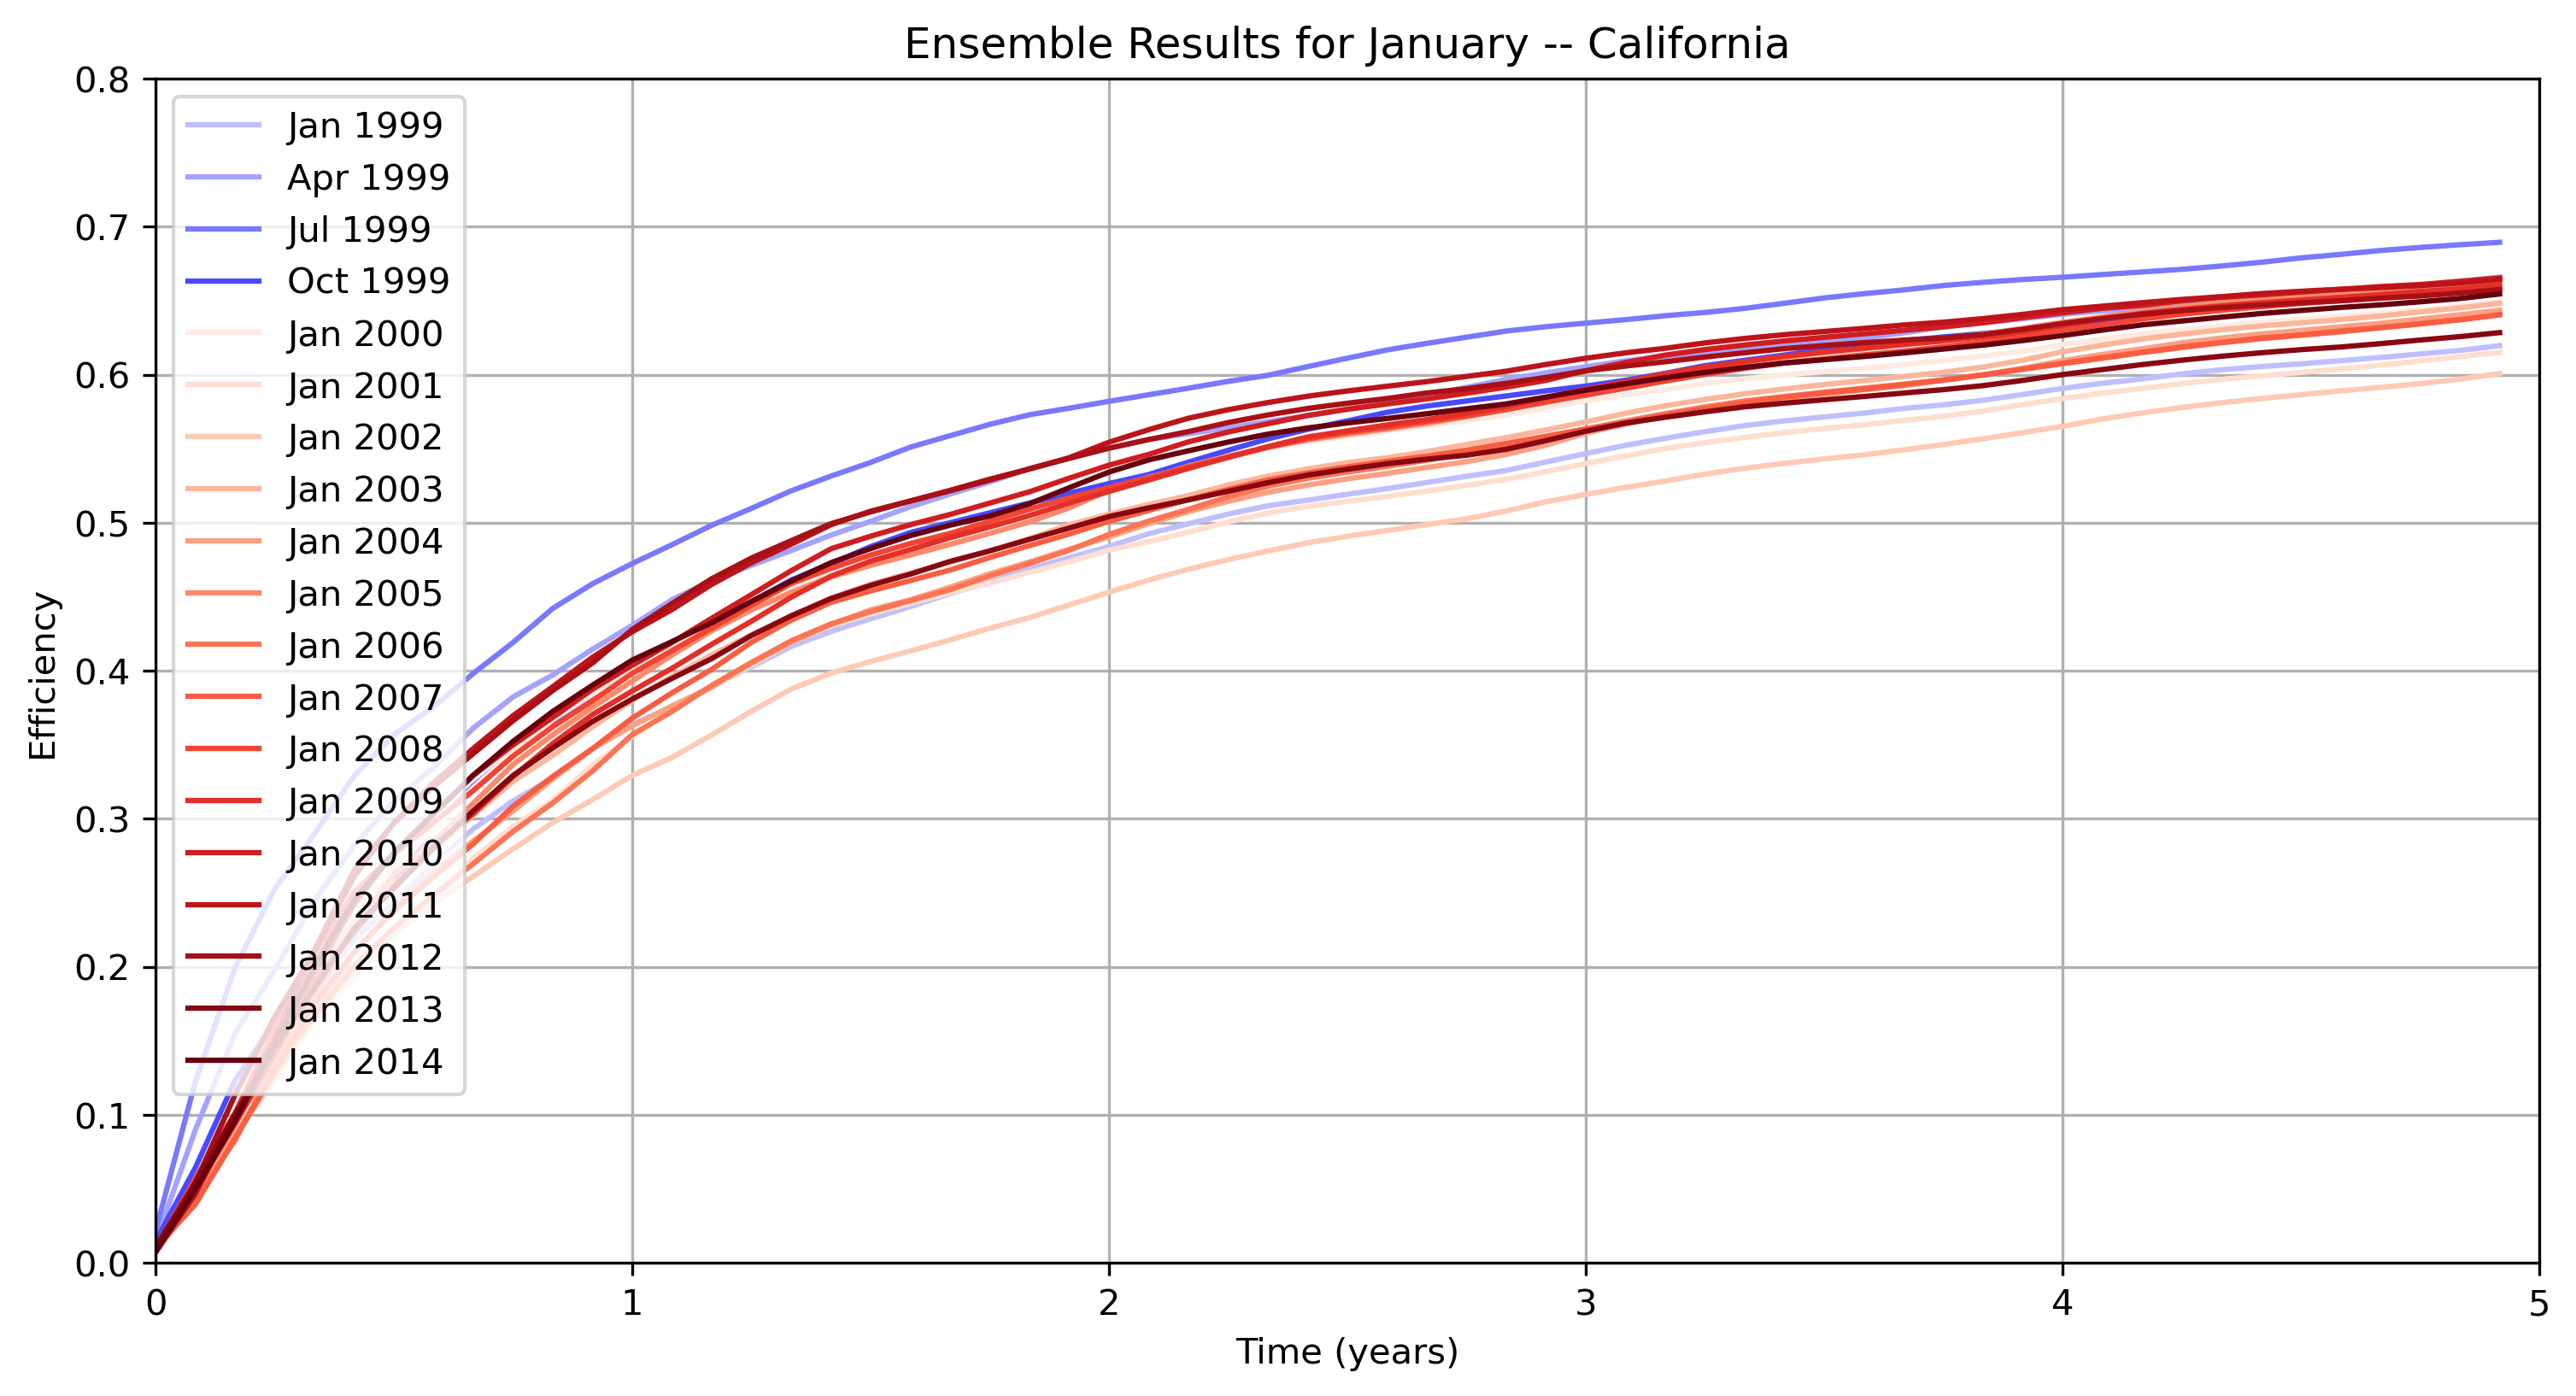

In [44]:
fig = plt.figure(figsize=(12,6),dpi=300)


color = iter(plt.cm.Reds(np.linspace(0, 1, 16)))
plt.plot(x_data[0:60]/12,y_data_01[0:60],c='#BFBFFF',label='Jan 1999')
plt.plot(x_data[0:60]/12,y_data_04[0:60],c='#A3A3FF',label='Apr 1999')
plt.plot(x_data[0:60]/12,y_data_07[0:60],c='#7879FF',label='Jul 1999')
plt.plot(x_data[0:60]/12,y_data_10[0:60],c='#4949FF',label='Oct 1999')


for i in range(1999,2015):
    
    c = next(color)
    print(i)
    if i>1999:           
        x_data = np.array(range(5*12))
        # if i == 2005:
        #     print('skip')
        #     y_data =  0.5*((globals()[f'exc_dic_{i+1}']/globals()[f'total_exc_alk_{i+1}']).values+(globals()[f'exc_dic_{i-1}']/globals()[f'total_exc_alk_{i-1}']).values); 

        # elif i == 2009:
        #     print('skip')
        #     y_data =  0.5*((globals()[f'exc_dic_{i+1}']/globals()[f'total_exc_alk_{i+1}']).values+(globals()[f'exc_dic_{i-1}']/globals()[f'total_exc_alk_{i-1}']).values); 

        # else:
        y_data =  (globals()[f'exc_dic_{i}']/globals()[f'total_exc_alk_{i}']).values; 
        y_data = y_data[~np.isnan(y_data)]  # get rid of nans
        plt.plot(x_data/12,y_data,label=f'Jan {i}',c=c)


plt.xlim([0,5])
plt.ylim([0,.8])
plt.xlabel('Time (years)')
plt.ylabel('Efficiency')
plt.grid()
plt.legend(fontsize=10)
plt.title('Ensemble Results for January -- California')


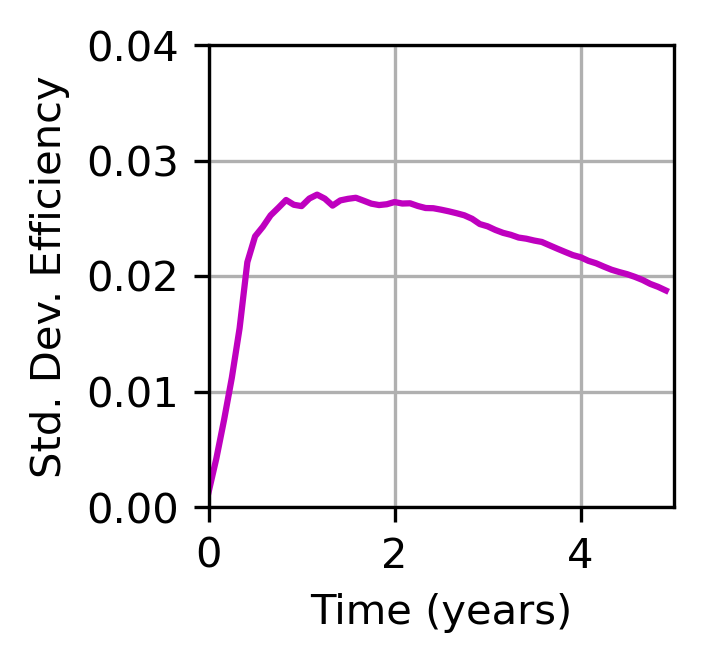

In [45]:
eff_stddev = [];
eff_mean   = [];
for j in range(0,60):
    eff = []
    for i in range(1999,2015):
        # if i == 2005:
        #     eff_local =  0.5*((globals()[f'exc_dic_{i-1}']/globals()[f'total_exc_alk_{i-1}']).values[j]+(globals()[f'exc_dic_{i+1}']/globals()[f'total_exc_alk_{i+1}']).values[j]); 
        # elif i == 2009:
        #     print('skip')
        #     eff_local =  0.5*((globals()[f'exc_dic_{i-1}']/globals()[f'total_exc_alk_{i-1}']).values[j]+(globals()[f'exc_dic_{i+1}']/globals()[f'total_exc_alk_{i+1}']).values[j]); 
        # else:
        eff_local =  (globals()[f'exc_dic_{i}']/globals()[f'total_exc_alk_{i}']).values[j]; 
        eff.append(eff_local)
    eff_stddev.append(np.std(eff)) 
    eff_mean.append(np.mean(eff))
eff_stddev = np.array(eff_stddev);
eff_mean = np.array(eff_mean);

fig = plt.figure(figsize=(2,2),dpi=300)
plt.plot(x_data/12,eff_stddev,'m')
plt.xlim([0,5])
plt.ylim([0,.04])
plt.xlabel('Time (years)')
plt.ylabel('Std. Dev. Efficiency')
plt.grid()

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


Text(0.5, 1.0, 'California Ensemble')

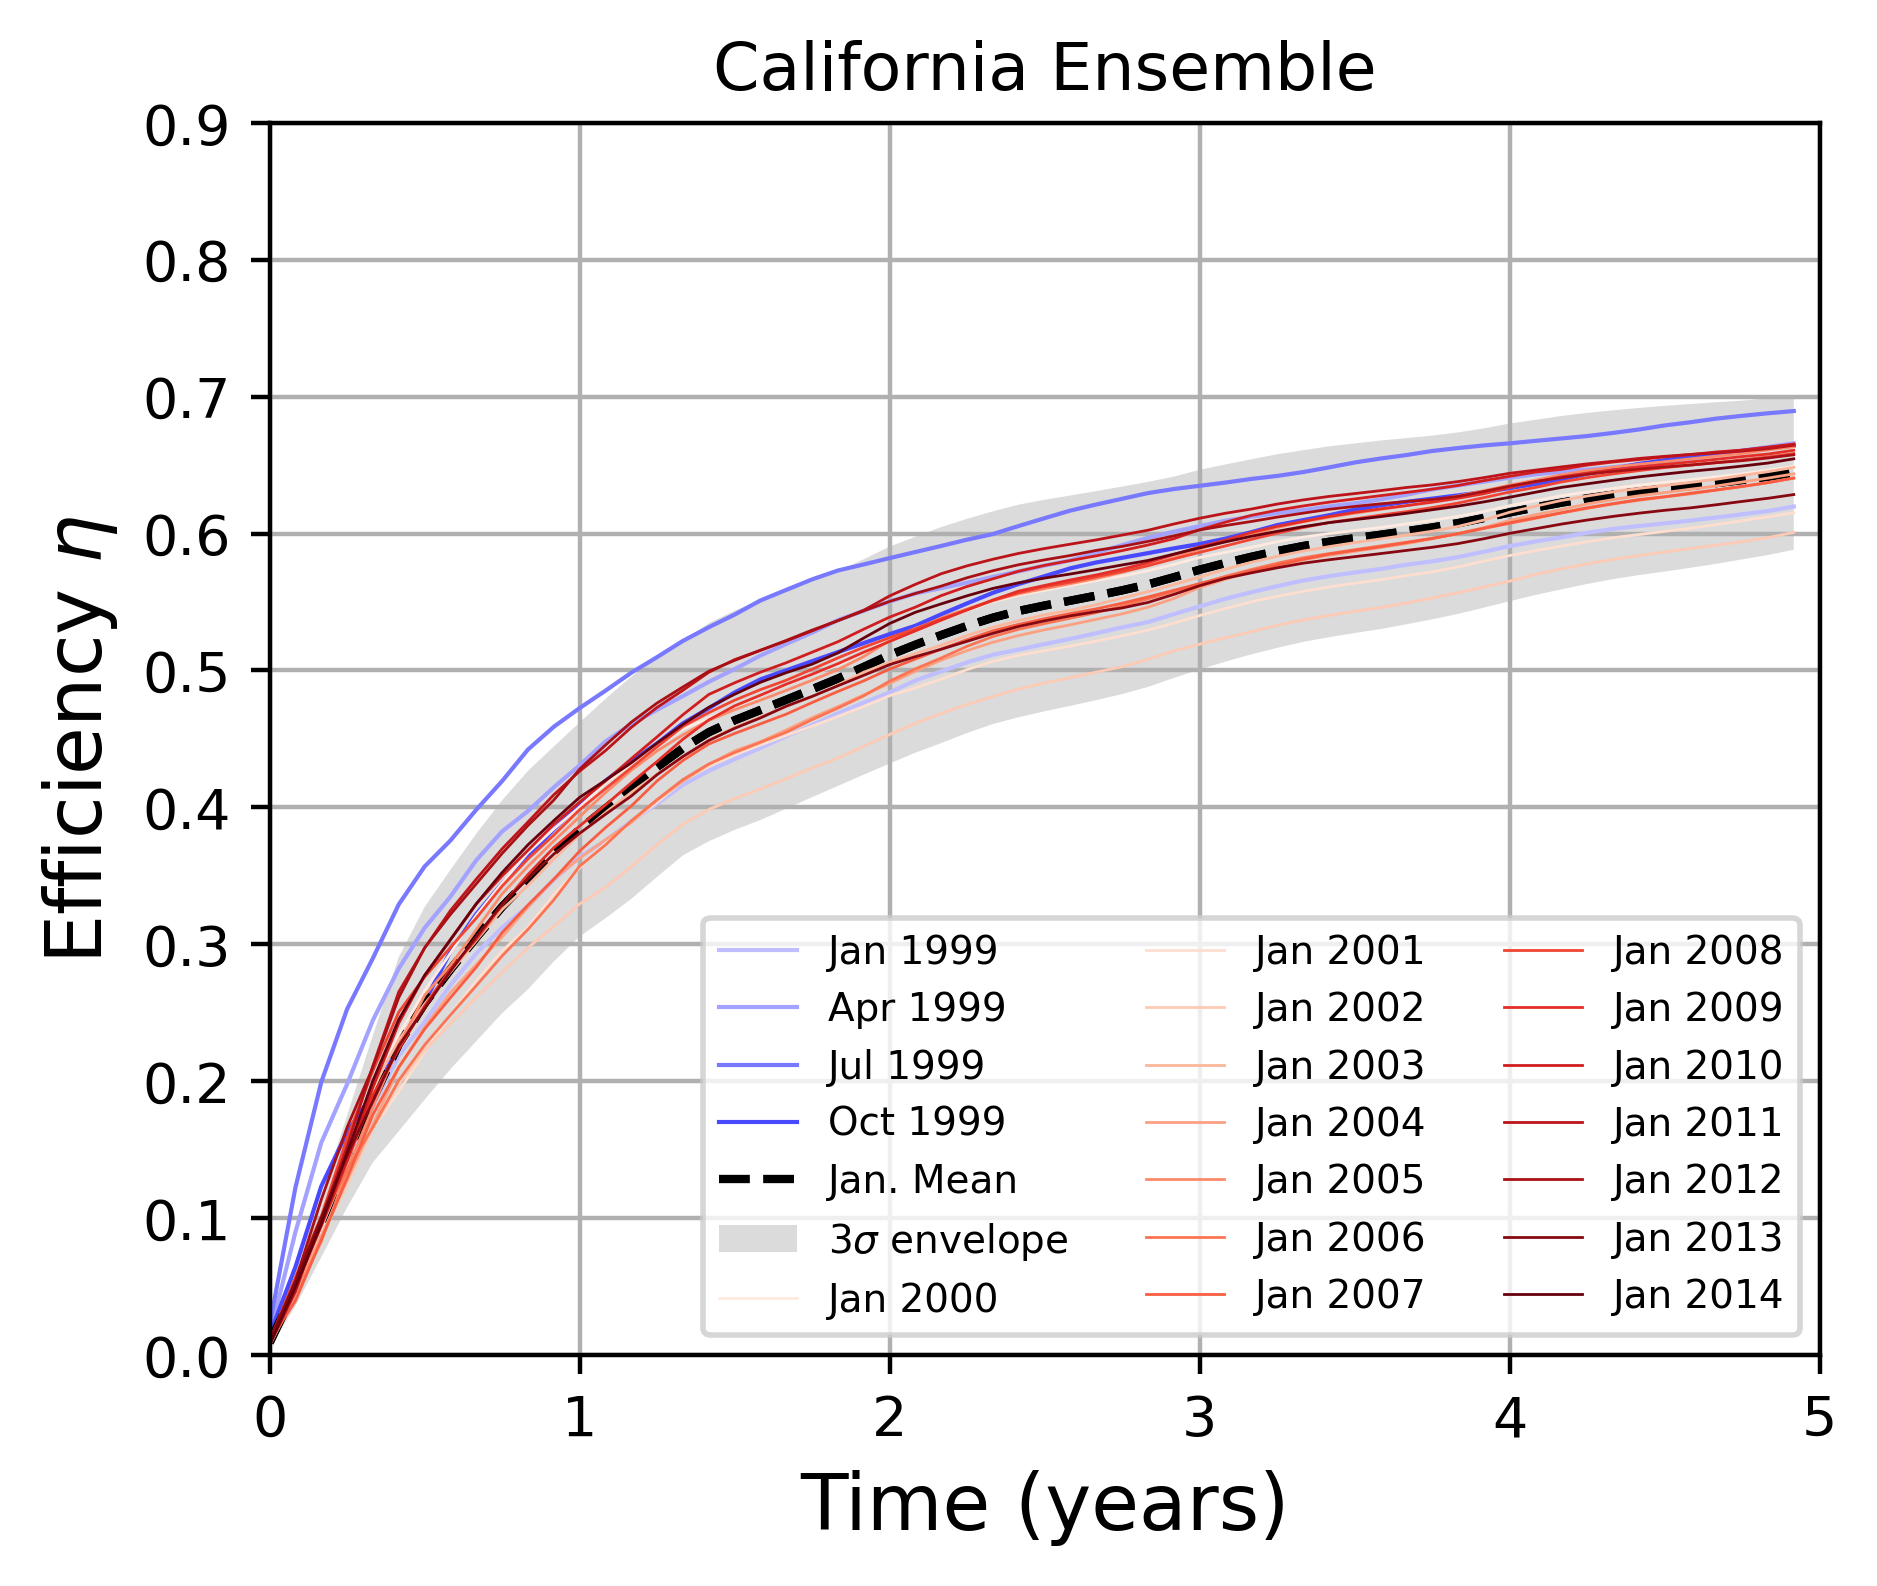

In [47]:
fig = plt.figure(figsize=(5,4),dpi=400)


color = iter(plt.cm.Reds(np.linspace(0, 1, 16)))
plt.plot(x_data[0:60]/12,y_data_01[0:60],c='#BFBFFF',label='Jan 1999',linewidth=0.75)
plt.plot(x_data[0:60]/12,y_data_04[0:60],c='#A3A3FF',label='Apr 1999',linewidth=0.75)
plt.plot(x_data[0:60]/12,y_data_07[0:60],c='#7879FF',label='Jul 1999',linewidth=0.75)
plt.plot(x_data[0:60]/12,y_data_10[0:60],c='#4949FF',label='Oct 1999',linewidth=0.75)
plt.plot(x_data/12,eff_mean,'--k',label='Jan. Mean')
plt.fill_between(x_data/12, eff_mean-3*eff_stddev, eff_mean+3*eff_stddev,facecolor='lightgrey',alpha=.8,label='3$\sigma$ envelope')



plt.plot(x_data/12,eff_mean,'--k')

for i in range(1999,2015):
    
    c = next(color)
    print(i)
    if i>1999:
        x_data = np.array(range(5*12))

        # if i == 2009:
        #     y_data =  0.5*((globals()[f'exc_dic_{i+1}']/globals()[f'total_exc_alk_{i+1}']).values+(globals()[f'exc_dic_{i-1}']/globals()[f'total_exc_alk_{i-1}']).values); 

        # elif i == 20013:
        #     print('skip')
        #     y_data =  0.5*((globals()[f'exc_dic_{i+1}']/globals()[f'total_exc_alk_{i+1}']).values+(globals()[f'exc_dic_{i-1}']/globals()[f'total_exc_alk_{i-1}']).values); 

        # else:
        y_data =  (globals()[f'exc_dic_{i}']/globals()[f'total_exc_alk_{i}']).values; 
        y_data = y_data[~np.isnan(y_data)]  # get rid of nans
        plt.plot(x_data/12,y_data,label=f'Jan {i}',c=c,linewidth=.5)
  
        #plt.plot(x_data,y_data[(i-1999)*12:(i-1999)*12+60],label=f'Jan {i}',c=c)

plt.xlim([0,5])
plt.ylim([0,.9])
plt.xlabel('Time (years)',fontsize=14)
plt.ylabel('Efficiency $\eta$',fontsize=14)
plt.grid()
plt.legend(fontsize=7,ncol=3,loc='lower right')
plt.title('California Ensemble')
